# Distributed Data Parallel - Multi GPU

We are performing DDP by distributing the data across multiple GPU. We are using the pretrained ResNet 50 Model. The model is trained on the spectrogram images generated from EEG signal data

In [2]:
import os
import shutil
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import resnet50
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.optim as optim
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import time

### Data Setup for Model Training

In [3]:
# Split the dataset into train, validation and test
def create_splits(data_dir, output_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    splits = {'train': train_size, 'val': val_size, 'test': test_size}
 
    assert sum(splits.values()) == 1, "Sum of split sizes should be 1."
 
    # Output directories for the splits
    for split in splits.keys():
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)
 
    # Iterate over each class directory
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        images = [img for img in os.listdir(class_dir) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        # Stratified splits
        train_val, test = train_test_split(images, test_size=splits['test'], random_state=42, stratify=None)
        train, val = train_test_split(train_val, test_size=splits['val'] / (splits['train'] + splits['val']), random_state=42, stratify=None)
 
        # Function to copy files to directories
        def copy_files(files, split):
            for f in files:
                src = os.path.join(class_dir, f)
                dst = os.path.join(output_dir, split, cls, f)
                shutil.copy(src, dst)
 
        # Copy files to respective split directories
        copy_files(train, 'train')
        copy_files(val, 'val')
        copy_files(test, 'test')
 
 
data_dir = '/kaggle/input/dataset24/dataset_24'
output_dir = '/kaggle/working/dataset_splits/'
create_splits(data_dir, output_dir)

### Data Augmentation using Dask

In [4]:
# Data Augmentation using dask
class CustomDataset(Dataset):
    def __init__(self, ddf, transform=None):
        self.ddf = ddf
        self.transform = transform
 
    def __len__(self):
        return len(self.ddf)
 
    def __getitem__(self, idx):
        row = self.ddf.iloc[idx]
        image_path = row['path']
        class_label = row['class']
        transformed_image = row['transformed_image']
        if isinstance(transformed_image, str):  # If transformed_image is a path
            image = Image.open(transformed_image)
        else:
            image = Image.fromarray(transformed_image)
        if self.transform:
            image = self.transform(image)
        return image, class_label
    
def add_augmented_images(root_dir, ddf):
 
    # check for data folder
    os.makedirs(root_dir, exist_ok=True)
    # iterate over dask dataframe containing transformed images
    for _, row in ddf.iterrows():
        class_name = row['class']
        image_path = row['path']
        class_dir = os.path.join(root_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        image_filename = os.path.basename(image_path)
        image_dest_path = os.path.join(class_dir, image_filename)
        if not os.path.exists(image_dest_path):
            # move images to the respective directory
            shutil.copy(image_path, image_dest_path)

def get_data_loader(batch_size, data_path, train=True):
    print("get data loader")
    if train:
        transform = transforms.Compose([
       transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
         transforms.RandomRotation(10),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
     ])
        
        image_paths = []
        for class_name in os.listdir(data_path):
            print(class_name)
            class_dir = os.path.join(data_path, class_name)
            for sample_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, sample_name)
                image_paths.append((class_name, image_path))
        # Using Dask Dataframes
        ddf = dd.from_pandas(pd.DataFrame(image_paths, columns=['class', 'path']), npartitions=4)
        # Create a custom dataset instance using your Dask DataFrame
        dataset = CustomDataset(ddf, transform=transform)
        add_augmented_images(data_path, ddf)
        # load data after augmentation
        dataset = datasets.ImageFolder(data_path, transform=transform)
 
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        dataset = datasets.ImageFolder(data_path, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=4, pin_memory=True)
    return data_loader

In [5]:
# Data directories
data_dir = '/kaggle/working/dataset_splits'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
test_dir = f'{data_dir}/test'

In [13]:
# Setup DDP
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("gloo", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)
# Function to save model checkpoints
def save_checkpoint(model, optimizer, epoch, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.module.state_dict(),  # Note: unwrap the model from DDP
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
 # Train model using AMP 
def train(model, loader, optimizer, criterion, scaler, rank, epoch, save_interval):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(rank), target.to(rank)
        optimizer.zero_grad()
        with autocast():  # automatic mixed precision
            output = model(data)
            loss = criterion(output, target)
           
           # losses = [torch.tensor(loss).to(rank) for _ in range(2)]
           # print(f"Loss : {losses}")
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        # if rank == 0 and batch_idx % save_interval == 0:
        #     save_checkpoint(model, optimizer, epoch, filename=f"checkpoint_epoch_{epoch}_batch_{batch_idx}.pth")
    return total_loss / len(loader), loss
 
# Validation Function
def validate_model(model, val_loader, rank):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(rank), labels.to(rank)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 
    print(f'Validation Accuracy: {100 * correct / total:.2f}%')
 
 
# Plot training loss curves
def Training_Loss(epochs, train_loss_gpu1, train_loss_gpu2, train_loss_overall):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_gpu1, label='GPU 1')
    plt.plot(epochs, train_loss_gpu2, label='GPU 2')
    plt.plot(epochs, train_loss_overall, label='Overall')
    plt.title('Training Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('DDP_Train_Loss_GPUs.png') 
    plt.show()
    
 # Perform training using DDP on multi-GPUs using ResNet50
def ddp_train(rank, world_size, epochs):
    global train_dir, val_dir
    train_loss_gpu1 = []
    train_loss_gpu2 = []
    train_loss_overall = []
    setup(rank, world_size)
    model = resnet50().to(rank)
    model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])
    batch_size = 256
    train_loader = get_data_loader(batch_size // world_size, train_dir, train=True)
    val_loader = get_data_loader(batch_size // world_size, val_dir, train=False)
    criterion = nn.CrossEntropyLoss().to(rank)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scaler = GradScaler()  # Initialize the gradient scaler for AMP
    save_interval = 100  # Interval for saving checkpoints
 
    for epoch in range(epochs):
        print("Epoch : ", epoch)
        ovr_loss, indi_loss = train(model, train_loader, optimizer, criterion, scaler, rank, epoch, save_interval)
        if rank == 0:
            print(f"Epoch {epoch+1}, Loss: {ovr_loss}")
            save_checkpoint(model, optimizer, epoch, filename=f"checkpoint_epoch_{epoch}.pth")

        # Gather loss from all GPUs
        losses = [torch.tensor(indi_loss).to(rank) for _ in range(world_size)]
        torch.distributed.all_gather(losses, indi_loss)

        # Store loss values from each GPU
        train_loss_gpu1.append(losses[0].item())  # Loss on GPU 1
        train_loss_gpu2.append(losses[1].item())  # Loss on GPU 2

        # Compute overall loss
        train_loss_overall.append(ovr_loss)
        if rank == 0:
            print(f"Epoch {epoch+1}, Loss: {ovr_loss}")
            save_checkpoint(model, optimizer, epoch, filename=f"checkpoint_epoch_{epoch}.pth")
            validate_model(model, val_loader, rank)
            
    # plot training loss on both the GPUs
    epochs = range(1, 11)
    Training_Loss(epochs, train_loss_gpu1, train_loss_gpu2, train_loss_overall)
 
    dist.destroy_process_group()
    

get data loader
get data loader
get data loader
get data loader
Epoch :  0
Epoch :  0
1.9504126030696582


/tmp/ipykernel_34/545651130.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  losses = [torch.tensor(indi_loss).to(rank) for _ in range(world_size)]


1.9504126030696582


/tmp/ipykernel_34/545651130.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  losses = [torch.tensor(indi_loss).to(rank) for _ in range(world_size)]


Epoch 1, Loss: 1.9504126030696582Epoch : 
 1
Validation Accuracy: 33.53%
Epoch :  1
1.5269767460349488
1.530231501754016
Epoch 2, Loss: 1.5269767460349488Epoch : 
 2
Validation Accuracy: 35.37%
Epoch :  2
1.45491626144272
1.4555049479415971
Epoch 3, Loss: 1.4555049479415971Epoch :  
3
Validation Accuracy: 47.52%
Epoch :  3
1.38295908170203631.3945156372573277

Epoch : Epoch 4, Loss: 1.3945156372573277
 4
Validation Accuracy: 44.62%
Epoch :  4
1.339332358069616
1.334198794340434
Epoch : Epoch 5, Loss: 1.339332358069616 
5
Validation Accuracy: 17.20%
Epoch :  5
1.280795356998705
1.2809853078159568
Epoch 6, Loss: 1.2809853078159568Epoch :  
6
Validation Accuracy: 38.61%
Epoch :  6
1.2256320576145225
1.2194150354560107
Epoch : Epoch 7, Loss: 1.2256320576145225
 7
Validation Accuracy: 53.45%
Epoch :  7
1.182648447584616
1.1813672556452555
Epoch 8, Loss: 1.182648447584616Epoch :  
8
Validation Accuracy: 48.60%
Epoch :  8
1.1346436694060287
1.1412185534630737
Epoch : Epoch 9, Loss: 1.14121855

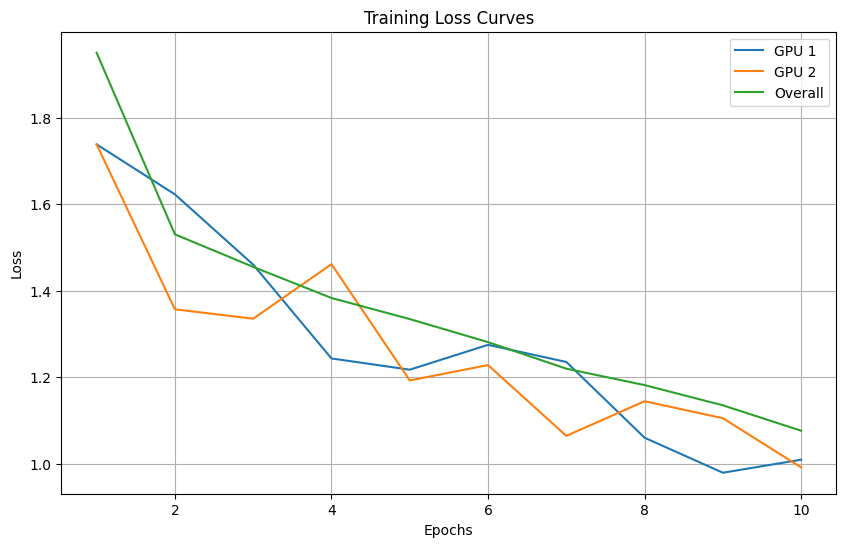

Process Process-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_34/545651130.py", line 103, in ddp_train
    validate_model(model, val_loader, rank)
  File "/tmp/ipykernel_34/545651130.py", line 44, in validate_model
    outputs = model(images)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/distributed.py", line 1515, in forward
    inputs, kwargs = self._pre_forward(*inputs, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/

In [14]:
# Training ResNet 50 pre-trained model on the custom spectrogram data using DDP on 2 GPUs
 
if __name__ == "__main__":
    world_size = 2 
    epochs = 10

    processes = []

    for rank in range(world_size):
        p = mp.Process(target=ddp_train, args=(rank, world_size, epochs))
        p.start()
        processes.append(p)
 
    for p in processes:
        p.join()